In [ ]:
!pip install mlflow boto3 awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import mlflow

In [ ]:
from google.colab import userdata
AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID')
AWS_DEFAULT_REGION = userdata.get('AWS_DEFAULT_REGION')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY')

In [ ]:
!aws configure set aws_access_key_id $AWS_ACCESS_KEY_ID
!aws configure set aws_secret_access_key $AWS_SECRET_ACCESS_KEY
!aws configure set default.region $AWS_DEFAULT_REGION

In [ ]:
!aws configure list

      Name                    Value             Type    Location
      ----                    -----             ----    --------
   profile                <not set>             None    None
access_key     ****************DU4P shared-credentials-file    
secret_key     ****************+wZh shared-credentials-file    
    region                us-east-2      config-file    ~/.aws/config


In [ ]:
EC2_INSTANCE_IP = "3.19.222.199"
PORT = 5000
PROTOCOL = "http"

In [ ]:
mlflow_tracking_uri = f"{PROTOCOL}://{EC2_INSTANCE_IP}:{PORT}/"

In [ ]:
EXPERIMENT_NAME = "Experiment 2 - BoW vs TF-IDF"

In [ ]:
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://my-mlflow-bucket-1299/673500106199894890', creation_time=1759851537821, experiment_id='673500106199894890', last_update_time=1759851537821, lifecycle_stage='active', name='Experiment 2 - BoW vs TF-IDF', tags={}>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlflow.models import infer_signature
import os

In [ ]:
df = pd.read_csv("dataset.csv") #preprocessed dataset
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [ ]:
df = df.dropna()
df = df.drop_duplicates()

In [ ]:
df[df['clean_comment'].str.strip() == '']

,clean_comment,category


In [ ]:
# step 1L Function to run the experiment

def run_experiment(vectorizer_type: str, ngram_range, vectorizer_max_features, vectorizer_name):
  if vectorizer_type.lower() == "bow":
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
  elif vectorizer_type.lower() == "tfidf":
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features= vectorizer_max_features)
  else:
    raise ValueError("Acceptable vectorizer types are: [bow, tfidf]")

  X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'],
                                                      test_size = 0.2, random_state = 42)
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)

  with mlflow.start_run():
    mlflow.set_tag("Mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
    mlflow.set_tag("experiment_type","FeatureEngineering")
    mlflow.set_tag("model_type", "RandomForestClassifer")

    #Add a description
    mlflow.set_tag("description",f"""RandomForest with {vectorizer_name},
                    ngram_range = {ngram_range}, max_features = {vectorizer_max_features}""")

    #LOG RANDOM FOREST PARAMS
    n_estimators = 200
    max_depth = 15


    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth",max_depth)

    #initialize model
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)

    #make predictions
    y_pred = model.predict(X_test)

    #Log accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy",accuracy)

    #log classification report
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in classification_rep.items():
      if isinstance(metrics,dict):
        for metric, value in metrics.items():
          mlflow.log_metric(f"{label}_{metric}", value)

    #log confustion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (10,8))
    sns.heatmap(conf_matrix, annot= True, fmt="d", cmap = "Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")

    #save and log confusion matrix
    file_name = "confusion_matrix.png"
    plt.savefig(file_name)
    mlflow.log_artifact(file_name)

    #log model
    mlflow.sklearn.log_model(
        model,
        name = f"Random_forest_model_{vectorizer_name}_{ngram_range}",
        signature = infer_signature(X_test, y_pred)
    )


🏃 View run puzzled-goose-950 at: http://3.19.222.199:5000/#/experiments/673500106199894890/runs/811340ad74024d8d965c5b541e6f1a14
🧪 View experiment at: http://3.19.222.199:5000/#/experiments/673500106199894890
🏃 View run learned-lark-146 at: http://3.19.222.199:5000/#/experiments/673500106199894890/runs/9843ba4d4cfc42bba9fcd1ae1586663a
🧪 View experiment at: http://3.19.222.199:5000/#/experiments/673500106199894890
🏃 View run indecisive-quail-285 at: http://3.19.222.199:5000/#/experiments/673500106199894890/runs/5f79e79c124a4eae9aebd011e0ddc36b
🧪 View experiment at: http://3.19.222.199:5000/#/experiments/673500106199894890
🏃 View run clumsy-stag-188 at: http://3.19.222.199:5000/#/experiments/673500106199894890/runs/1eb8f66b82e84822b52f3172ff80b09c
🧪 View experiment at: http://3.19.222.199:5000/#/experiments/673500106199894890
🏃 View run brawny-colt-255 at: http://3.19.222.199:5000/#/experiments/673500106199894890/runs/c18b2f458ee4466d90bb8bf08585bc12
🧪 View experiment at: http://3.19.222

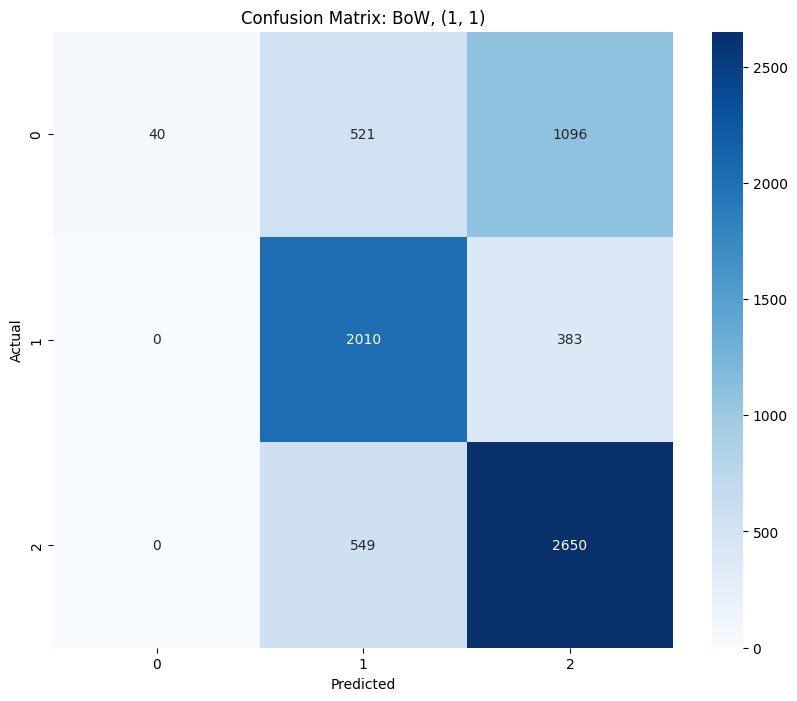

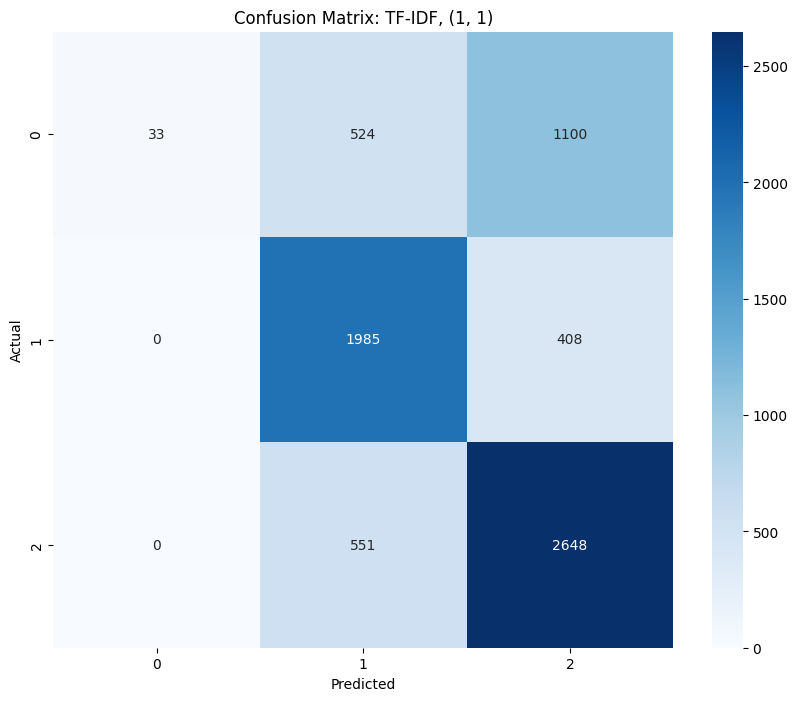

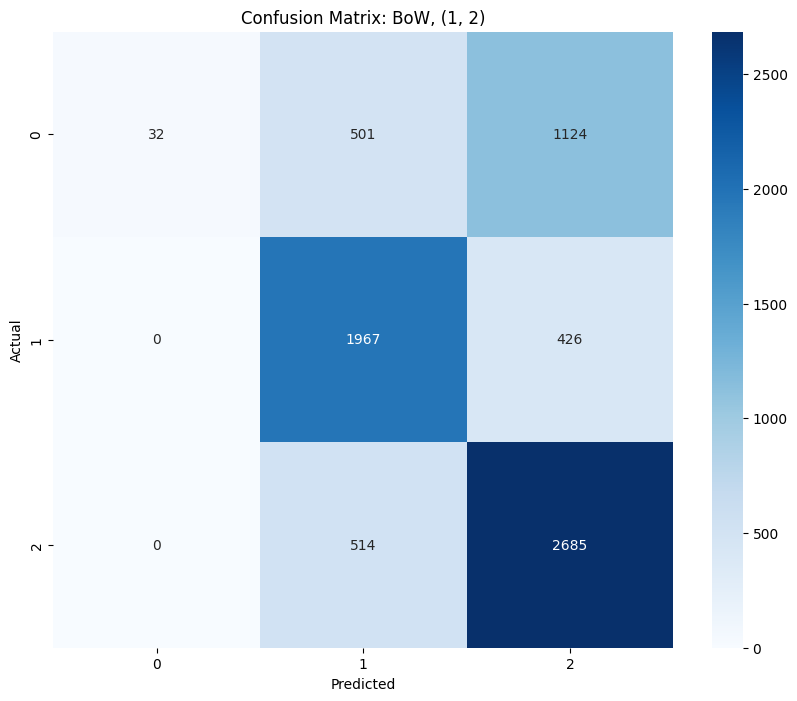

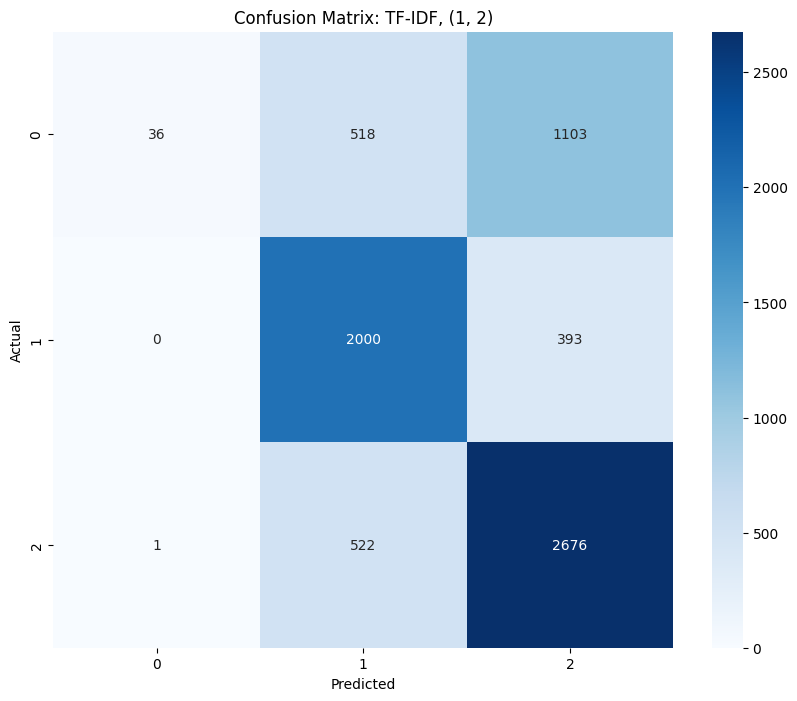

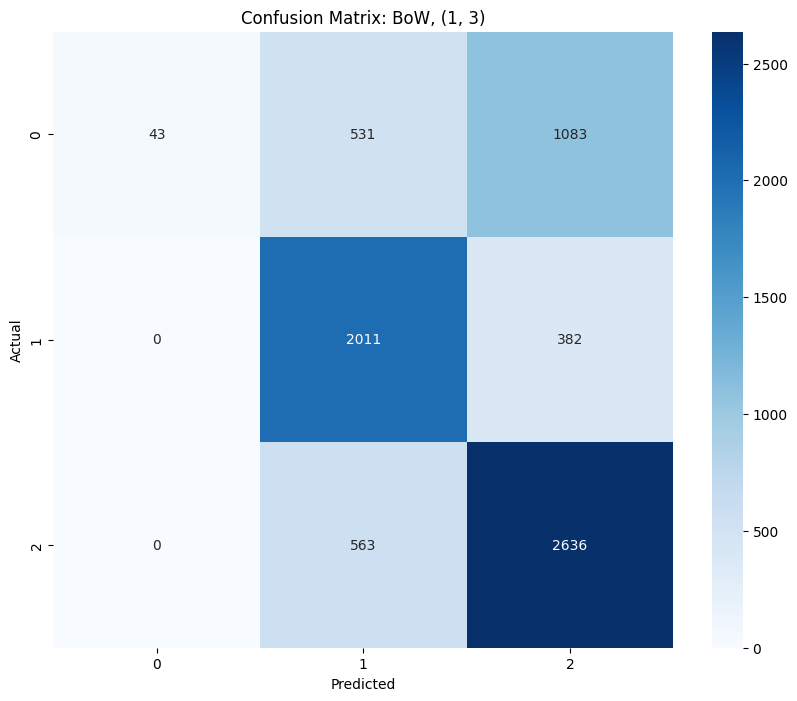

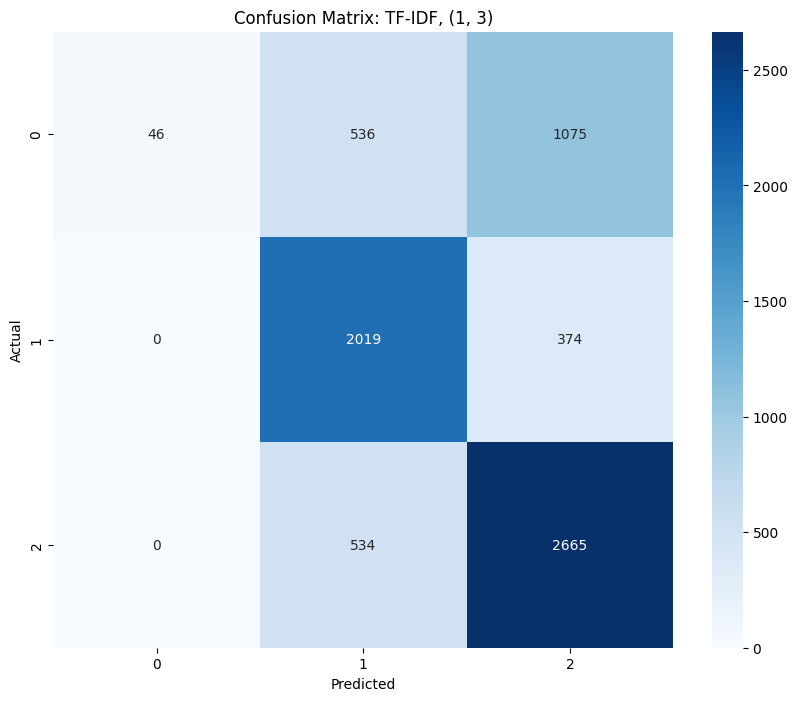

In [ ]:
#Run experiments for Bow and TF-IDF with different n-grams
ngram_ranges = [(1,1),(1,2),(1,3)]
max_features = 5000

for ngram_range in ngram_ranges:
  run_experiment("bow", ngram_range, max_features, vectorizer_name = "BoW")
  run_experiment("TFIDF", ngram_range, max_features, vectorizer_name = "TF-IDF")
